In [132]:


import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from data_structures import Annotation,EcgSignal,Features
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5] 
import wfdb
from wfdb import processing
from tqdm import tqdm
from ecgdetectors import Detectors


In [133]:
def downloadData():

	try:							# creating necessary directories
		os.mkdir('database')
		os.mkdir('database/cudb')
		os.mkdir('database/vfdb')
	except:
		pass 
	
	wfdb.dl_database('vfdb', dl_dir='database/vfdb')	# download mitMVAdb
	wfdb.dl_database('cudb', dl_dir='database/cudb')		# download cudb


In [134]:

def extract_file(database,path):

    dat_files_all = []

    for dirname, _, filenames in os.walk(path):
        dat_files = [ fi for fi in filenames if fi.endswith(".dat") ]
        for filename in dat_files:
            dat_files_all.append(filename)
    print( str(database) +' : '+str(len(dat_files_all)))

    return dat_files_all

In [135]:

def createAnnotationArray(indexArray,labelArray,hi,NSRsymbol):

	annotations = []

	for i in range(len(indexArray)):

		annotations.append(Annotation(index=indexArray[i],label=labelArray[i]))

	distributedAnnotations = createDistributedAnnotations(annotationArray=annotations,hi=hi,NSRsymbol=NSRsymbol)

	return distributedAnnotations


def createDistributedAnnotations(annotationArray,hi,NSRsymbol):

	labelArray=[]

	localLo = 0
	localHi = annotationArray[0].index
	currLabel = NSRsymbol

	## The following is similar to interval covering algorithms

	## We are assuming the first unannotated part to be NSR

	for i in range(localLo,localHi):

		labelArray.append(currLabel)


	## now for the other actual annotated segments

	for i in range(1,len(annotationArray)):			
													# interval
		localLo = annotationArray[i-1].index
		localHi = annotationArray[i].index
		currLabel = annotationArray[i-1].label

		for j in range(localLo,localHi):

			labelArray.append(currLabel)

	## for the last segment

	localLo = annotationArray[len(annotationArray)-1].index
	localHi = hi
	currLabel = annotationArray[len(annotationArray)-1].label

	for j in range(localLo, localHi):
		labelArray.append(currLabel)

	return labelArray				# point wise annotation array


In [136]:
def createCUDBAnnotation(annotationIndex,annotationArr,lenn):


	li = []							# initialize

	for i in range(lenn):						
		li.append('notVF')					

	st=-1
	en=-1


	for i in range(len(annotationArr)):

		if(annotationArr[i]=='N'):				

			li[i]='NSR'

	for i in range(len(annotationArr)):

		if(annotationArr[i]=='['):

			st = annotationIndex[i]

		if(annotationArr[i]==']'):

			en = annotationIndex[i]

			for j in range(st,en+1):

				li[j]='VF'
			st = -1
			en = -1

	if(st!=-1):

		for j in range(st,lenn):
			li[j] = 'VF'

	return np.array(li)

In [137]:
def processCUDBFile(files_annexe,Te,list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q):

	signals, fields = wfdb.rdsamp(files_annexe) 		# collect the signal and metadata
	Fs=fields['fs']								# sampling frequency 	

	channel1Signal = []							# channel 1 signal

	for i in signals:
												# separating the two channels
		channel1Signal.append(i[0])


	channel1Signal = np.array(channel1Signal)	# converting lists to numpy arrays

	annotation = wfdb.rdann(files_annexe, 'atr')# collecting the annotation
	annotIndex = annotation.sample				# annotation indices
	annotSymbol = annotation.symbol				# annotation symbols

							# creating the annotation array
	annotationArray = createCUDBAnnotation(annotationIndex=annotIndex,annotationArr=annotSymbol,lenn=len(channel1Signal))

	nSamplesIn1Sec = Fs					# computing samples in one episode
	nSamplesInEpisode = Te * Fs
	i=0									# episode counter
	counter=0
	while((i+nSamplesInEpisode)<len(channel1Signal)):		# loop through the whole signal

		j = i + nSamplesInEpisode

		VF = 0												# VF indices
		NSR = 0												# NSR indices
		notVF = 0											# Not VF indices
		Noise = 0											# Noise indices


		for k in range(i,j):

			if(annotationArray[k]=='VF'):
				VF+=1
			elif(annotationArray[k]=='NSR'):	# unnecessary
				NSR += 1
			else:
				notVF +=1

		if(Noise==0):						# noisy episode

			if(VF<1000):
				ecgEpisode = EcgSignal(signal=channel1Signal[i:j],annotation='VF' if VF>notVF else 'NotVF',channel='Only_Channel',source='cudb',Fs=Fs)
				
				list_label.append(ecgEpisode.annotation)
				list_signal.append(ecgEpisode.signal)
				list_channel.append(ecgEpisode.channel)
				list_fs.append(ecgEpisode.Fs)
				list_source.append(ecgEpisode.source)
				counter_negative=0
				inverted_signal=False		
			
					
				RDAmpM,RDAmpSD,qrsa,qrsasd,point_X,qrs_inds,r_peaks,point_qs=compute_rpeaks_features(ecgEpisode.signal,ecgEpisode.Fs,"cudb",counter,inverted_signal)
				list_feature_RDAmpM.append(RDAmpM)
			
				list_feature_RDAmpSD.append(RDAmpSD)
				list_feature_qrsa.append(qrsa)
				list_feature_qrsasd.append(qrsasd)
				list_point_s.append(point_X)
				list_r_peaks.append(r_peaks)
				list_qs.append(point_qs)
				list_q.append(qrs_inds)
			"""
			
			elif(2*NSR>=nSamplesInEpisode):
				ecgEpisode = EcgSignal(signal=channel1Signal[i:j],annotation='NSR',channel='Only_Channel',source='cudb',Fs=Fs)
				list_label.append(ecgEpisode.annotation)
				list_signal.append(ecgEpisode.signal)
				list_channel.append(ecgEpisode.channel)
				list_fs.append(ecgEpisode.Fs)
				list_source.append(ecgEpisode.source)
				
				RDAmpM,RDAmpSD,qrsa,qrsasd=compute_rpeaks_features(ecgEpisode.signal,ecgEpisode.Fs,"cudb")
				list_feature_RDAmpM.append(RDAmpM)
			
				list_feature_RDAmpSD.append(RDAmpSD)
				list_feature_qrsa.append(qrsa)
				list_feature_qrsasd.append(qrsasd)

			
				
			else:
				ecgEpisode = EcgSignal(signal=channel1Signal[i:j],annotation='NotVF',channel='Only_Channel',source='cudb',Fs=Fs)
				list_label.append(ecgEpisode.annotation)
				list_signal.append(ecgEpisode.signal)
				list_channel.append(ecgEpisode.channel)
				list_fs.append(ecgEpisode.Fs)
				list_source.append(ecgEpisode.source)
				
				RDAmpM,RDAmpSD,qrsa,qrsasd=compute_rpeaks_features(ecgEpisode.signal,ecgEpisode.Fs,"cudb")
				list_feature_RDAmpM.append(RDAmpM)
			
				list_feature_RDAmpSD.append(RDAmpSD)
				list_feature_qrsa.append(qrsa)
				list_feature_qrsasd.append(qrsasd)

			
			"""	



		i += nSamplesIn1Sec								# sliding the window


In [138]:

def processMITMVADBFile(path_annexe,Te,list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q):


	#display_ecg(path_annexe,5000)


	signals, fields = wfdb.rdsamp(path_annexe) # A 2d numpy array storing the physical signals from the record.

	


	 										# collect the signal and metadata
	Fs=fields['fs']							# sampling frequency 

	channel1Signal = []						# channel 1 signal
	channel2Signal = []						# channel 2 signal
	counter_positive=0
	counter_negative=0
	for i in signals:						# separating the two channels
		channel1Signal.append(i[0])			
		channel2Signal.append(i[1])

	
	#channel1Signal=inverte_signal(channel1Signal)
	#channel2Signal=inverte_signal(channel2Signal)
	

	channel1Signal = np.array(channel1Signal)		# converting lists to numpy arrays
	channel2Signal = np.array(channel2Signal)

	annotation = wfdb.rdann(path_annexe, 'atr')		# collecting the annotation
	annotIndex = annotation.sample					# annotation indices
	annotSymbol = annotation.aux_note				# annotation symbols


	

	for i in range(len(annotSymbol)):

		annotSymbol[i] = annotSymbol[i].rstrip('\x00') # because the file contains \x00 

		if(annotSymbol[i]=='(N'):		# N = NSR
			annotSymbol[i]='(NSR'

		elif (annotSymbol[i] == '(VFIB'):	# VFIB = VF
			annotSymbol[i] = '(VF'




			# creating the annotation array
	annotationArr = createAnnotationArray(indexArray=annotIndex,labelArray=annotSymbol,hi=len(channel1Signal),NSRsymbol='(NSR') 
	


	nSamplesIn1Sec = Fs					# computing samples in one episode
	nSamplesInEpisode = Te * Fs	


	i=0									# episode counter

	
	counter=0

	while((i+nSamplesInEpisode)<len(channel1Signal)):
			# loop through the whole signal

		j = i + nSamplesInEpisode	

		VF = 0													# VF indices
		notVF = 0												# Not VF indices
		Noise =0												# Noise indices

	
		
		
		for k in range(i,j):

			if(annotationArr[k]=='(VF'):
				VF+=1
			else:						# anything other than VF
				notVF +=1

			if(annotationArr[k]=='(NOISE'):
				Noise += 1

		if(VF>1000 and Noise==0):
			k=k+1						# noisy episode
			
			counter+=1
            
			counter_negative=0
		
																			# saving channel 1 signal
			ecgEpisode = EcgSignal(signal=channel1Signal[i:j],annotation='VF' if VF>notVF else 'NotVF',channel='Channel1',source='MITMVAdb',Fs=Fs)
			
			list_label.append(ecgEpisode.annotation)
			list_signal.append(ecgEpisode.signal)
			list_channel.append(ecgEpisode.channel)
			list_fs.append(ecgEpisode.Fs)
			list_source.append(ecgEpisode.source)

			#compute_RR_intervall(ecgEpisode.signal,ecgEpisode.Fs,"vfdb")
			
			inverted_signal=False
			
			
			for x in ecgEpisode.signal: 
				if x<0 :
					counter_negative+=1 
			if counter_negative > len(ecgEpisode.signal)/2:
				
				ecgEpisode.signal=np.array(inverte_signal(ecgEpisode.signal))
			


			
			RDAmpM,RDAmpSD,qrsa,qrsasd,point_X,qrs_inds,r_peaks,point_qs=compute_rpeaks_features_vf(ecgEpisode.signal,ecgEpisode.Fs,"vfdb",counter)
			#print("RDAmpM:"+str(RDAmpM))
			#print("RDAmpSD"+str(RDAmpSD))
			#print("qrsa:"+str(qrsa))
			#print("qrsasd"+str(qrsasd))
			list_feature_RDAmpM.append(RDAmpM)
			
			list_feature_RDAmpSD.append(RDAmpSD)

			list_feature_qrsa.append(qrsa)
			list_feature_qrsasd.append(qrsasd)

			list_point_s.append(point_X)
			list_r_peaks.append(r_peaks)
			list_qs.append(point_qs)
			list_q.append(qrs_inds)

			

																			
			"""																# saving channel 2 signal
			ecgEpisode = EcgSignal(signal=channel2Signal[i:j], annotation='VF' if VF > notVF else 'NotVF', channel='Channel2', source='MITMVAdb', Fs=Fs)
			list_label.append(ecgEpisode.annotation)
			list_signal.append(ecgEpisode.signal)
			list_channel.append(ecgEpisode.channel)
			list_fs.append(ecgEpisode.Fs)
			list_source.append(ecgEpisode.source)
			
			RDAmpM,RDAmpSD,qrsa,qrsasd=compute_rpeaks_features(ecgEpisode.signal,ecgEpisode.Fs)
			list_feature_RDAmpM.append(RDAmpM)
			
			list_feature_RDAmpSD.append(RDAmpSD)
			list_feature_qrsa.append(qrsa)
			list_feature_qrsasd.append(qrsasd)
			
			
			"""
		



		i += nSamplesIn1Sec								# sliding the window

	

In [139]:
def compute_RR_intervall(ecg,fs,db,figsize=(20, 10),title="peak detection"):
    r_peaks, _ = find_peaks(ecg, distance=35,height=0.65)
    
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    #hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
     # r_peaks, _ = find_peaks(ecg, distance=15,height=0.25) for > 200
    N = ecg.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(ecg, color='#3979f0', label='Signal')
    ax_left.plot(r_peaks, ecg[r_peaks], 'rx', label='Peak', markersize=12)
      
    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    

    plt.show()
 

In [140]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    final_list=[]
    for i in unique_list:
        final_list.append(abs(i))
    
    return final_list

In [141]:
def return_s(r_peaks,signal,db):
    if db=="cudb":
        k=2
    else:
        k=1
    r_peaks1=unique(r_peaks)
    r_peaks=sorted(r_peaks1)
    signal=signal.tolist()
    point_x=[]
    point_y=[]
    if list(r_peaks) and list(signal) != False : 
        #print("##############################      signal   start              ############################")
        #print(r_peaks)
        #print(signal)
        for i in range(len(r_peaks)):
            #print("##############################      signal   interval         ############################")
            
            if i < len(r_peaks)-1:
                #print(i)
                
                if r_peaks[i]==r_peaks[i+1]:
                    pass
                else :
                    flag_limit=r_peaks[i]+(r_peaks[i+1]-r_peaks[i])/k
                    x_index=signal[r_peaks[i]:int(round(flag_limit))].index(min(signal[r_peaks[i]:int(round(flag_limit))]))
                    y_index=min(signal[r_peaks[i]:int(round(flag_limit))])

                    #point_S.append([r_peaks[i],r_peaks[i]+x_index])
                    #print((r_peaks[i],r_peaks[i]+x_index))
                    
                    #point_S.append(s_index+counter)
                    point_x.append(r_peaks[i]+x_index)
                    point_y.append(y_index)


            else:
                #print(i)
                if r_peaks[i]==len(signal) or (len(signal)-r_peaks[i])<150:
                    pass
                else:

                    flag_limit=r_peaks[i]+((len(signal)-1)-r_peaks[i])/2
                    #print(flag_limit)
                    x_index=signal[r_peaks[i]:int(round(flag_limit))].index(min(signal[r_peaks[i]:int(round(flag_limit))]))
                    y_index=min(signal[r_peaks[i]:int(round(flag_limit))])
                    #point_S.append([r_peaks[i],r_peaks[i]+x_index])
                    #print((r_peaks[i],r_peaks[i]+x_index))
                    point_x.append(r_peaks[i]+x_index)
                    point_y.append(y_index)

        
        #print("########################################## signal end ###################################")
    else :
        point_x=[]
        point_y=[]
    #print(point_x)
    #print(point_y)
    return point_x,point_y
                

In [142]:
def inverte_signal(signal):
    new_signal=[]
    for i in signal:
        if i <0:
            new_signal.append(abs(i))
        elif i==0:
            new_signal.append(0)
        else:
            new_signal.append(-i)
    return new_signal

In [143]:
def compute_signed_area(signal,qs_point):
    if len(qs_point)==0:
        QRSaM=0
        QRSaSD=0
    else:
        sum_signed_area=0
        diff=0  
        for i in qs_point:
            signed_area=0
            for j in signal[i[0]:i[1]]:
                signed_area+=abs(j)
            sum_signed_area+=signed_area
        
        QRSaM=sum_signed_area/len(qs_point)
        for k in qs_point:
            signed_area=0  
            for l in signal[k[0]:k[1]]:
                signed_area+=abs(l)
            diff+=pow(signed_area-QRSaM,2)
        QRSaSD=np.sqrt(diff/len(qs_point))

    return QRSaM,QRSaSD


In [144]:
def compute_rpeaks_features_vf(signal,FS,db,counter):
    #r_peaks,_=wfdb.processing.find_peaks(signal)

    r_peaks,_=find_peaks(signal,distance=20,prominence=max(signal)/3)

    qrs_inds=[]
    point_X=[]
    point_y=[]

    point_X ,point_y=return_s(r_peaks,signal,db)
    #peaks_hr(signal,r_peaks,qrs_inds,point_X,point_y, 'VF Heartbeat', counter ,saveto=True)
    point_qs=[]
    

    for i in range(len(point_X)-1):
        max_list=[]
        for j in range(1,len(point_X)):
            
            point_qs.append([point_X[i],point_X[j]])

    #print("the list of s point:"+str(point_X))
    #print("list of q indices "+str(qrs_inds))
    #print("list of R peaks"+str(r_peaks))
    #print("that the intervall computed qs :"+str(point_qs))
    
    qrsam,QRSAd=compute_signed_area(signal,point_qs)

    #print(qrsam)
    #print(QRSAd)


    r_peaks=signal[r_peaks]

     
    if len(r_peaks)==0:
        RPampM=0
        RPampSD=0
    else:
        sum_rpeaks=0
        for i in r_peaks:
            sum_rpeaks=sum_rpeaks+i
        RPampM=sum_rpeaks/len(r_peaks)

        sum_peaks2=0
        for j in r_peaks:
            sum_peaks2=sum_peaks2+pow(j-RPampM,2)
        RPampSD=np.sqrt(sum_peaks2/len(r_peaks)) 
    return RPampM,RPampSD,qrsam,QRSAd,point_X,qrs_inds,r_peaks,point_qs
    

In [154]:
def compute_rpeaks_features(signal,FS,db,counter,inverted_signal):
    #r_peaks,_=wfdb.processing.find_peaks(signal)
    #qrs_inds = processing.qrs.gqrs_detect(sig=signal, fs=FS, d_sig=None, adc_gain=None, adc_zero=None, threshold=0.5, hr=75, QS=0.50, QT=0.35, RTmin=0.25, RTmax=0.33)
    if db=='vfdb':
        qrs_inds=wfdb.processing.gqrs_detect(sig=signal, fs=FS, QRSa=55,QRSamin=30)
        #qrs_inds=wfdb.processing.gqrs_detect(sig=signal, fs=FS, QT=0.8)
        if inverted_signal==False:
            r_peaks,_=find_peaks(signal, distance=60,height=float(max(signal)*55/100))
        else :
            r_peaks,_=find_peaks(signal, distance=60,height=float(min(signal)/3)) 


    else:
        #xqrs = processing.XQRS.Conf(hr_init=75, hr_max=200, hr_min=25, qrs_width=0.1, qrs_thr_init=1, qrs_thr_min=0, ref_period=0.2, t_inspect_period=0)
        #qrs_inds = processing.xqrs_detect(sig=signal, fs=FS,conf=xqrs)
        qrs_inds=wfdb.processing.gqrs_detect(sig=signal, fs=FS, hr=75, RRmin=0.28, RRmax=2.4, QS=0.07, QT=0.35, RTmin=0.22, RTmax=0.4, QRSa=750, QRSamin=130)
        r_peaks, _ = find_peaks(signal, distance=75,prominence=1)
  

    if len(qrs_inds) == 0:
        qrs_inds=[]
    
    point_X ,point_y=return_s(r_peaks,signal,db) #
    peaks_hr(signal,r_peaks,qrs_inds,point_X,point_y, 'Healthy Heartbeat',counter,saveto=True)
    point_qs=[]


    for i in range(len(qrs_inds)):
        max_list=[]
        for j in range(len(point_X)):
            
            if qrs_inds[i] <point_X[j] :
                max_list.append(point_X[j])
            elif qrs_inds[i] == point_X[j]:
                max_list.append(-1)
            else:
                pass
        if max_list == [] or min(max_list) == -1 :
            pass
        else:
            point_s=min(max_list)
            point_qs.append([qrs_inds[i],point_s])

    #print("the list of s point:"+str(point_X))
    #print("list of q indices "+str(qrs_inds))
    #print("list of R peaks"+str(r_peaks))
    #print("that the intervall computed qs :"+str(point_qs))
    
    qrsam,QRSAd=compute_signed_area(signal,point_qs)

    #print(qrsam)
    #print(QRSAd)


    r_peaks=signal[r_peaks]

     
    if len(r_peaks)==0:
        RPampM=0
        RPampSD=0
    else:
        sum_rpeaks=0
        for i in r_peaks:
            sum_rpeaks=sum_rpeaks+i
        RPampM=sum_rpeaks/len(r_peaks)

        sum_peaks2=0
        for j in r_peaks:
            sum_peaks2=sum_peaks2+pow(j-RPampM,2)
        RPampSD=np.sqrt(sum_peaks2/len(r_peaks)) 
    return RPampM,RPampSD,qrsam,QRSAd,point_X,qrs_inds,r_peaks,point_qs
    




In [146]:
def print_r_peaks(sig, peak_inds, title, figsize=(20, 10), saveto=None):
    
    fig, ax_left = plt.subplots(figsize=figsize)
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
   
    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
   
    ax_left.tick_params('y', colors='#3979f0')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

In [147]:
def peaks_hr(sig, peak_inds,qrs_inds,point_x,point_Y, title,counter,saveto=None, figsize=(20, 10)):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    #hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
     
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    #ax_left.plot(peak_inds, sig[peak_inds], 'x', 
                 #color='#8b0000', label='Peak', markersize=12)
    #ax_left.plot(point_x,point_Y, 'x', 
                 #color='green', label='Peak', markersize=12)
    #ax_left.plot(qrs_inds,sig[qrs_inds], 'x',
                 #color='blue', label='Peak', markersize=12)     
   

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')

   
    
    if saveto is not None:
        plt.savefig("file2212_"+str(counter), dpi=600)
    plt.show()


In [148]:
def processDB(Te,file_name,database,list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q):
	print('Processing files '+str(database))

	for i in file_name:	
		files=os.path.join("database",os.path.join(str(database),str(i)))
		

		if database=="vfdb":

			if (os.path.isfile(files)):
			
				fileNo=i.split(".")
				files_annexe=os.path.join("database",os.path.join(str(database),str(fileNo[0])))

				processMITMVADBFile(files_annexe,Te,list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q)

		elif database=="cudb":

			if (os.path.isfile(files)):
			
				fileNo=i.split(".")
				files_annexe=os.path.join("database",os.path.join(str(database),str(fileNo[0])))
				print(files_annexe)

				processCUDBFile(files_annexe,Te,list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q)

	return list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q


In [149]:
def create_Dataframe_location( ):

	try:							# creating the necessary directories
		os.mkdir('dataframe')
		os.mkdir('dataframe/cudb')
		os.mkdir('dataframe/vfdb')
	except:
		pass
				# process MITMVA db files
	



In [150]:
def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [151]:
def to_dataframe(Te,database,file_name):
    df = pd.DataFrame(columns=['label','signal','channel','db','fs'])
    list_label=[]
    list_signal=[]
    list_channel=[]
    list_fs=[]
    list_source=[]
    list_feature_RDAmpM=[]
    list_feature_RDAmpSD=[]
    list_feature_qrsa=[]
    list_feature_qrsasd=[]
    list_point_s=[]
    list_r_peaks=[]
    list_qs=[]
    list_q=[]
    list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q=processDB(Te,file_name,database,list_label,list_signal,list_channel,list_fs,list_source,list_feature_RDAmpM,list_feature_RDAmpSD,list_feature_qrsa,list_feature_qrsasd,list_point_s,list_r_peaks,list_qs,list_q)
    df['label']=list_label
    df['signal']=list_signal
    df['channel']=list_channel
    df['fs']=list_fs
    df['db']=list_source
    df['RDAmpM']=list_feature_RDAmpM
    df['RDAmpSD']=list_feature_RDAmpSD
    df['QRsa']=list_feature_qrsa
    df['QRaSD']=list_feature_qrsasd
    df["S"]=list_point_s
    df["Q"]=list_q
    df["QS"]=list_qs
    df["R"]=list_r_peaks
    return df

# Preprocesing on DB

In [152]:
file_name_cudb=extract_file("cudb database","database//cudb")
file_name_vfdb=extract_file("vfdb database","database//vfdb")


cudb database : 35
vfdb database : 22


In [153]:
df=to_dataframe(8,"vfdb",file_name_vfdb)

Processing files vfdb


KeyboardInterrupt: 

Processing files cudb
database\cudb\cu01


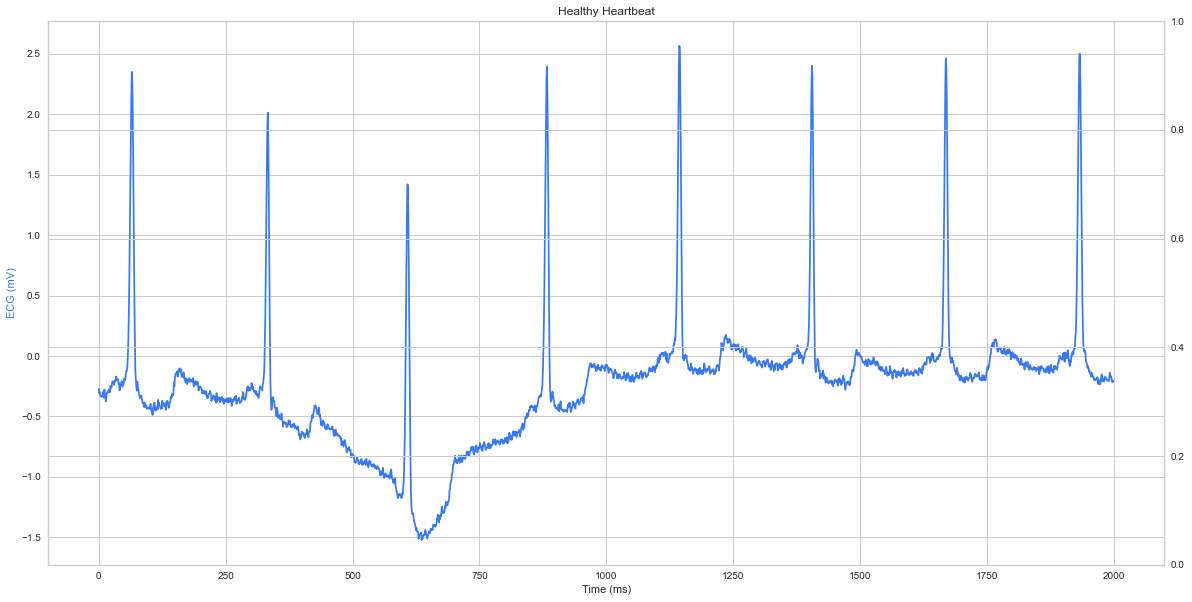

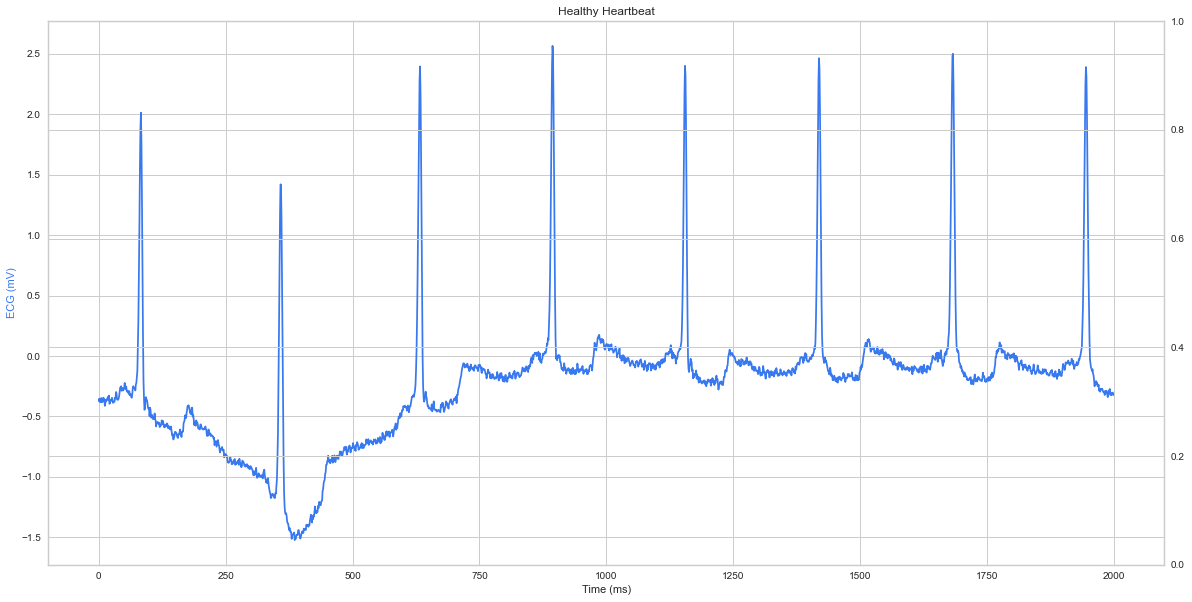

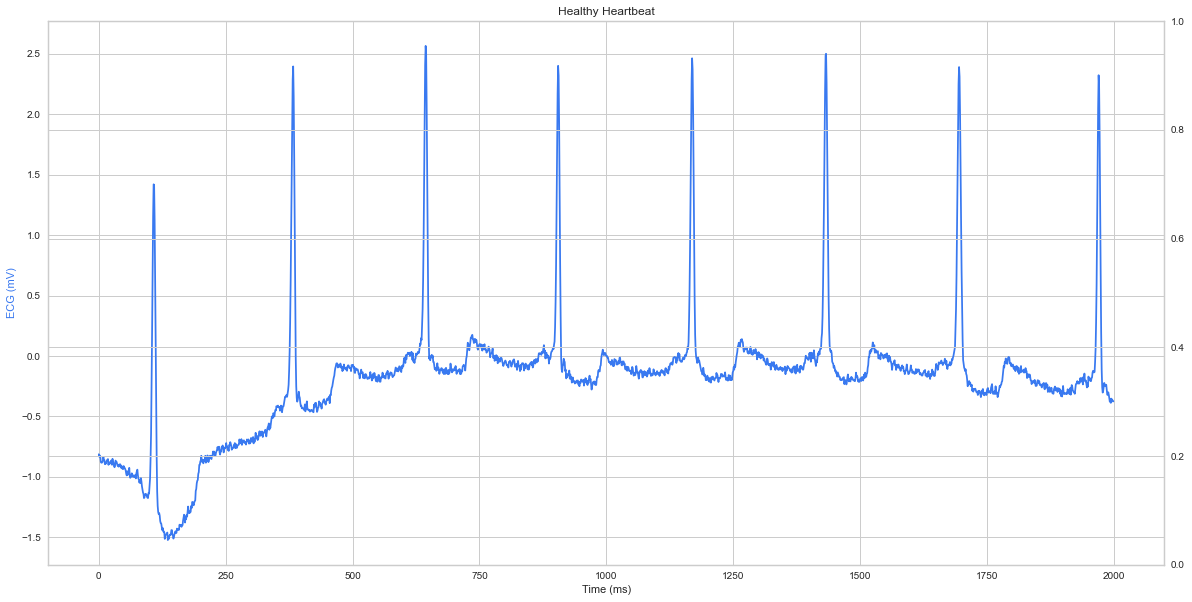

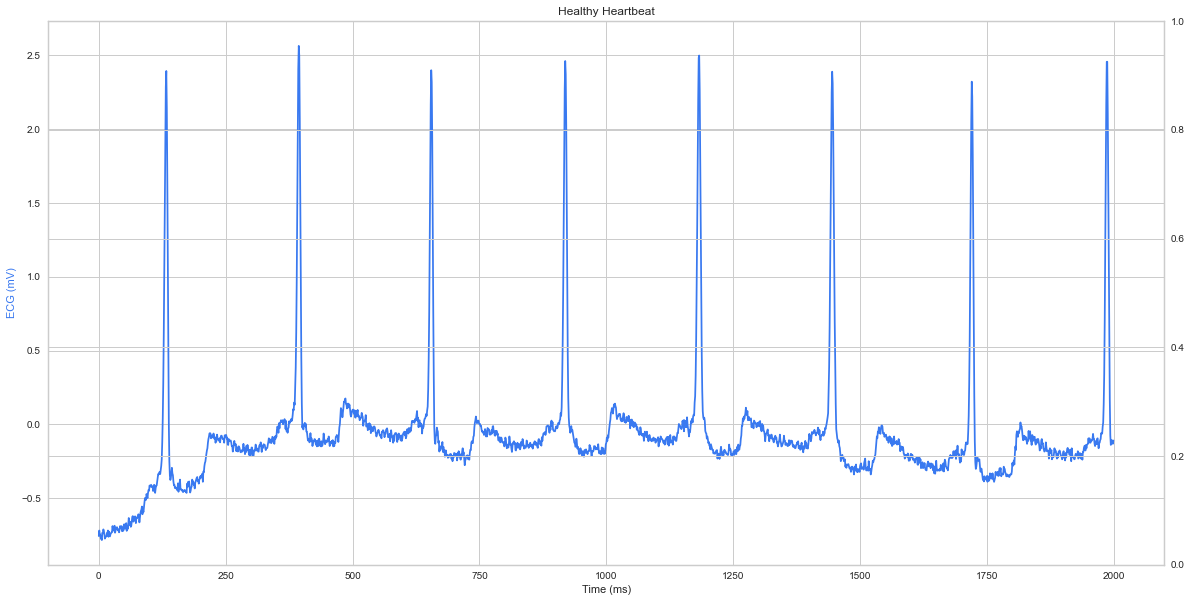

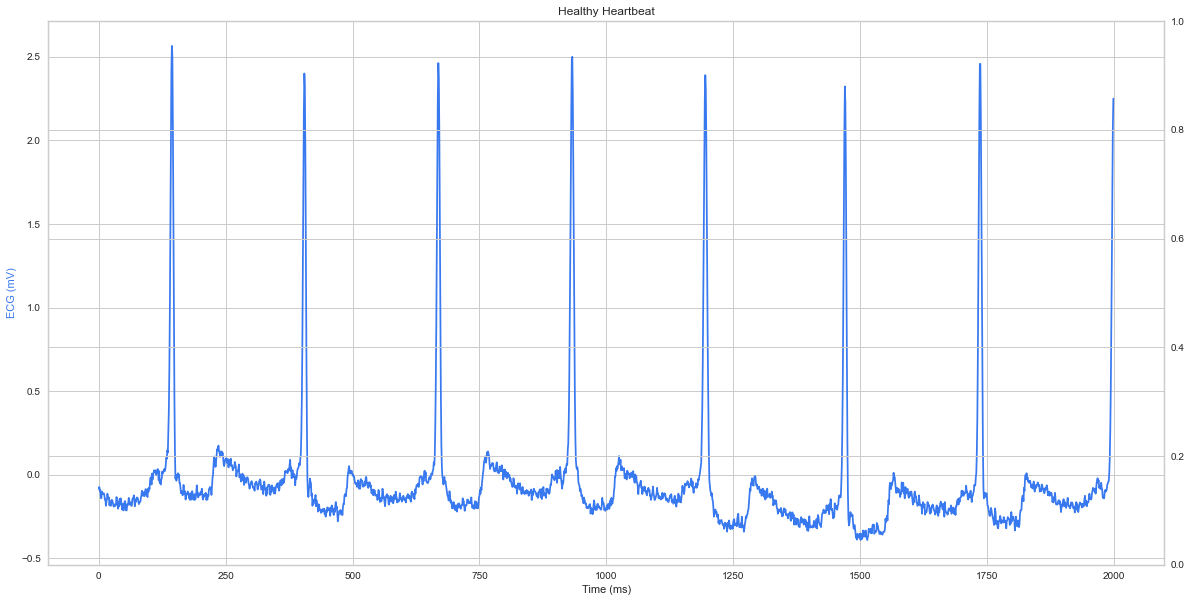

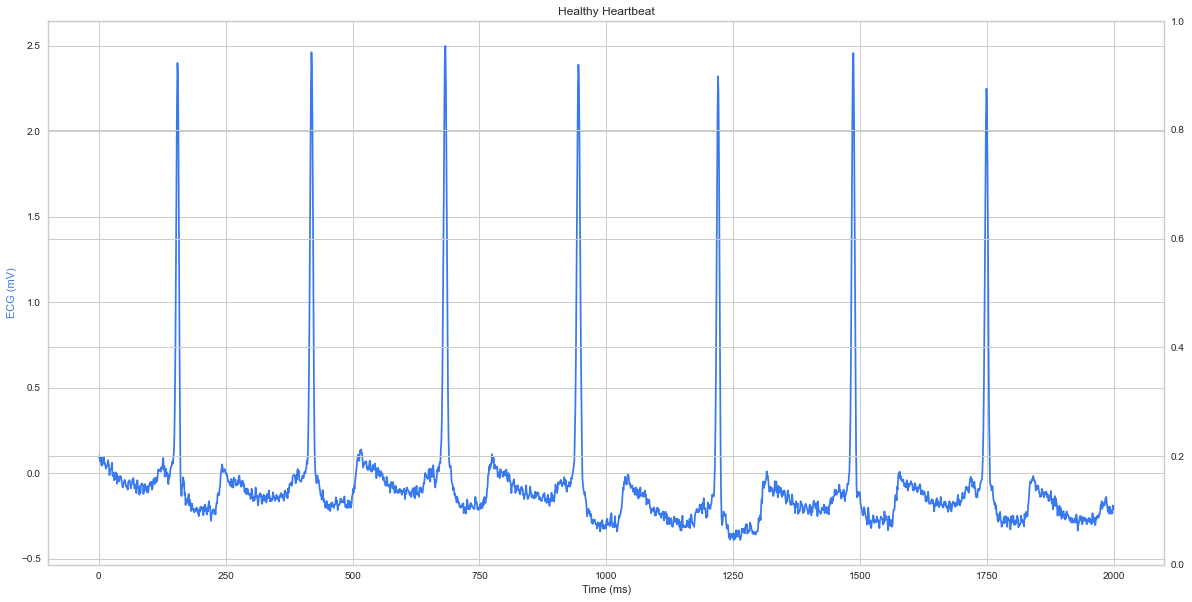

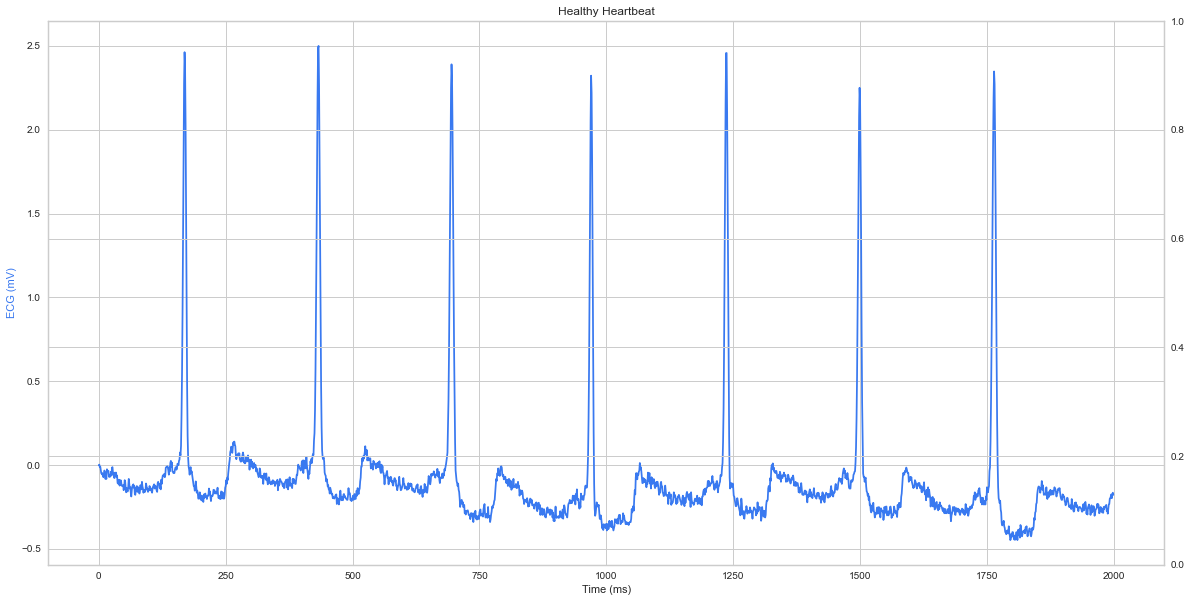

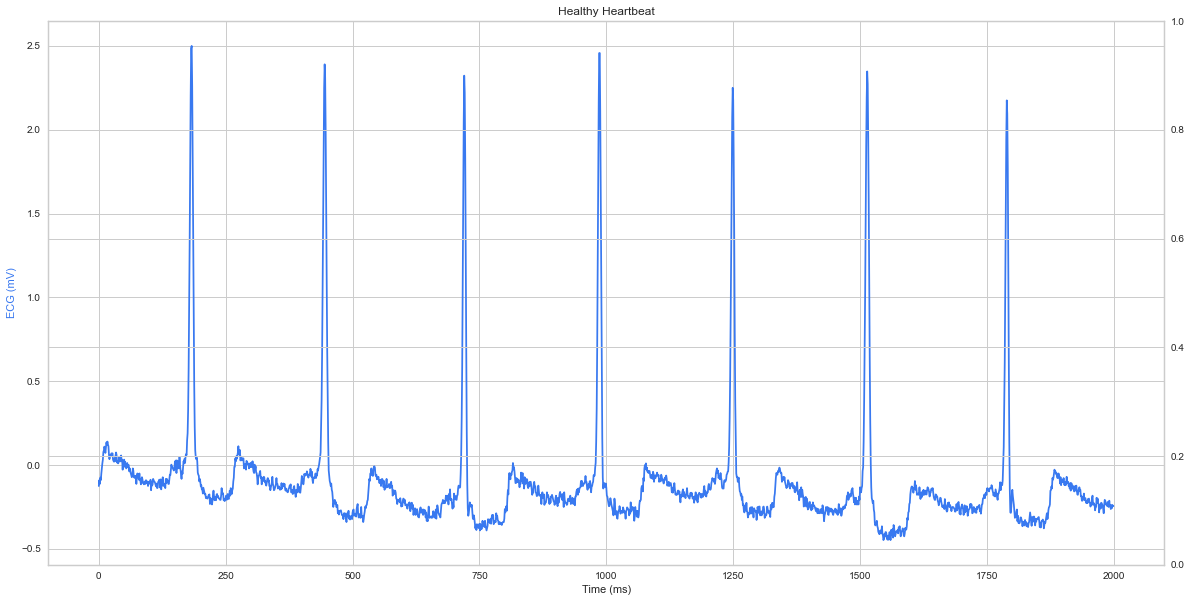

KeyboardInterrupt: 

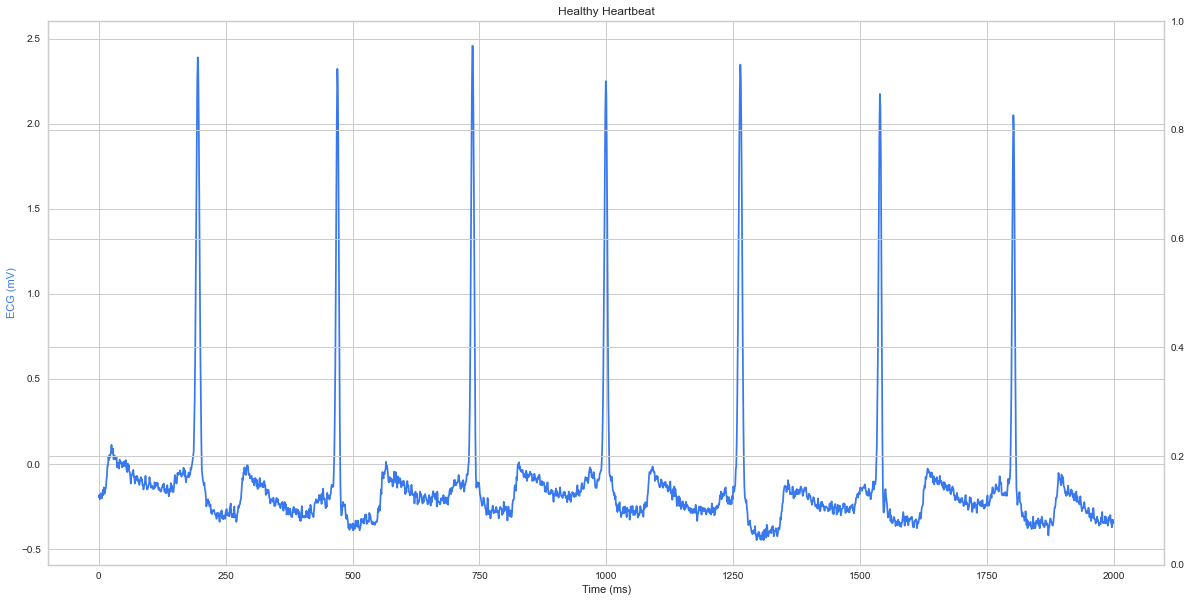

In [155]:
df1=to_dataframe(8,"cudb",file_name_cudb)


# Cleaning

In [ ]:
df_vf_not_clean=df1

In [ ]:

df_vf_not_clean=df_vf_not_clean[df_vf_not_clean["QRaSD"]/df_vf_not_clean["QRsa"] <1.1]

In [ ]:
df_vf_not_clean=df[df["QRaSD"]<14]

In [ ]:


df_vf_not_clean=df_vf_not_clean[ df_vf_not_clean["QRaSD"] >0]


In [ ]:
df_vf_not_clean

In [ ]:
for i in  df_vf_not_clean.index:
    if  i > 1359:
        print(i)
        df=df_vf_not_clean.drop(index=i, axis=0)
        df_vf_not_clean=df

In [ ]:
list_RDAmpM=[]
list_RDAmpSD=[]
list_qrsa=[]
list_qrsasd=[]
list_point_X=[]
list_qrs_inds=[]
list_r_peaks=[]
list_point_qs=[]
for i in df_vf_not_clean.index :
    RDAmpM,RDAmpSD,qrsa,qrsasd,point_X,qrs_inds,r_peaks,point_qs=compute_rpeaks_features(df_vf_not_clean["signal"][i],250,"vfdb", counter=0)
    list_RDAmpM.append(RDAmpM)
    list_RDAmpSD.append(RDAmpSD)
    list_qrsa.append(qrsa)
    list_qrsasd.append(qrsasd)
    list_point_X.append(point_X)
    list_qrs_inds.append(qrs_inds)
    list_r_peaks.append(r_peaks)
    list_point_qs.append(point_qs)



In [ ]:
df_vf_not_clean['RDAmpM']=list_RDAmpM
df_vf_not_clean['RDAmpSD']=list_RDAmpSD
df_vf_not_clean['QRsa']=list_qrsa
df_vf_not_clean['QRaSD']=list_qrsasd
df_vf_not_clean["S"]=list_point_X
df_vf_not_clean["Q"]=list_qrs_inds
df_vf_not_clean["QS"]=list_point_qs


In [ ]:
df_vf_not_clean["R_corrected"]=list_r_peaks

In [ ]:
df_vf_not_clean.to_excel("db_vf.xlsx",
             sheet_name='Sheet_name_1') 

# Data Statitic 

In [ ]:
df_vf.info()


In [ ]:
df_vf['QRsa'].isna().sum()

In [ ]:
df_stat=assess_NA(df_vf)

In [ ]:
print(df_stat)

In [ ]:
print(df_vf[df_vf["label"] == "NotVF"].count())

In [ ]:
print(df_vf[df_vf["label"] == "VF"].count())

In [ ]:
print(df_vf[df_vf["QRaSD"] == 0].count())

In [ ]:
print(df_vf[df_vf["QRsa"] == 0].count())

In [ ]:
print(df_vf[df_vf["RDAmpM"] == 0].count())

In [ ]:
print(df_vf[df_vf["RDAmpSD"] == 0].count())

# Upload labled dataset

In [ ]:
df_vf=pd.read_excel("db_vf (1).xlsx")

In [ ]:
df_vf=df_vf.append(df_vf_not_clean)

In [ ]:
df_vf=df_vf[df_vf["QRaSD"]>0]
df_vf=df_vf[df_vf["RDAmpSD"]>0]

In [ ]:
df_vf.to_excel("db_vf.xlsx",
             sheet_name='Sheet_name_1') 

# Data_visualisation




In [ ]:
import plotly.express as px

fig = px.scatter(df_vf, x="QRaSD", y="QRsa", color="label")
fig.show()

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df_vf, y="QRaSD", x="QRsa",z="RDAmpSD",color="label")
fig.show()

In [ ]:
fig = px.scatter(df_vf, y="QRaSD", x="RDAmpM", color="label")
fig.show()

In [ ]:
import plotly.express as px

fig = px.histogram(df_vf, x="RDAmpSD",color="label")
fig.show()

In [ ]:

fig = px.histogram(df_vf, x="QRaSD", color="label")
fig.show()

In [ ]:

fig = px.histogram(df_vf, x="QRsa", color="label")
fig.show()

In [ ]:

fig = px.histogram(df_vf, x="RDAmpM", color="label")
fig.show()

In [ ]:

fig = px.histogram(df_vf, x="RDAmpM", color="label")
fig.show()

# Smooth

In [ ]:

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where


# define dataset
X=df_vf[["QRaSD","QRsa","RDAmpM"]]
y=df_vf["label"]
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)


# Feature importance

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
#
#
# Load the wine datasets


# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=1)
#
# Feature scaling
#
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Train the mode
#
forest= RandomForestClassifier()
forest.fit(X_train_std, y_train.values.ravel())
importances = forest.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()
#

# Grid search and Cross validations and SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plot
from sklearn.metrics import classification_report,plot_roc_curve
from sklearn.model_selection import train_test_split
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics


gammas = [5]		# list of gamma values
Cs = [100]
list_accuracy=[]									# list of C values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=1) 		
													# get train test split

						# exhaustive grid search
for gamma in gammas:
	for C in Cs:
		clf = SVC(kernel='rbf', gamma=gamma, C=C,probability=True)
		clf.fit(X_train, y_train)
		Y_pred = clf.predict(X_test)
		cm = confusion_matrix(y_test,Y_pred)
		y_pred_proba = clf.predict_proba(X_test)[::,1]
		print(classification_report(y_test, Y_pred, target_names=["VF","NotVF"]))
		accuracy = float(cm.diagonal().sum())/len(y_test)
		print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)
		list_accuracy.append(accuracy)

# Grid search and stratified 10 folds Cross validations and SVM

In [ ]:

from sklearn.model_selection import cross_val_score,StratifiedKFold

from sklearn.svm import SVC

gammas = [5]		# list of gamma values
Cs = [100]


for i in gammas:
    for j in Cs:
        
        model=SVC(kernel='rbf', gamma=5, C=100,probability=True,random_state = np.random.RandomState(0))
        kfold=StratifiedKFold(n_splits=10)
        score=cross_val_score(model,X,y,cv=kfold,scoring='accaruc')
        print("Cross Validation score are: {}".format(score))
        print("Average Cross score :{}".format(score.mean()))

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.get_scorer_names()

# Plot confusion matrix SVM

In [ ]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score,StratifiedKFold

from sklearn.svm import SVC

In [ ]:
def cross_val_predict(model, kfold , X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X,y):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba


In [ ]:

def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [ ]:


actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, ["NotVF", "VF"])


# validation curves

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
param_range = np.arange(1, 250, 2)

train_scores, test_scores = validation_curve(model,
                            X, y, param_name="gamma", param_range=param_range,
                            cv=4, scoring="accuracy", n_jobs=-1)

In [ ]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
#
# Plot the model scores (accuracy) against the paramater range
#
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import ValidationCurve




# Create the validation curve visualizer
cv = StratifiedKFold(5)
param_range = range(100)

viz = ValidationCurve(model, param_name="C", param_range=param_range,
    logx=True, cv=cv, scoring="accuracy", n_jobs=8,
)

viz.fit(X, y)
viz.show()

# stratified 10 folds Cross validations logistic Regression

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression



logreg=LogisticRegression()
stratifiedkf=StratifiedKFold(n_splits=10)


score=cross_val_score(logreg,X,y,cv=stratifiedkf )
print("Cross Validation {} are {}".format(x,score))
print("Average Cross {} score :{}".format(x,score.mean()))

# Grid search on Neural networks 

In [ ]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, accuracy_score

from keras.layers import Dropout

In [ ]:
def create_model(learning_rate,activation_function,init,neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 3,kernel_initializer = init,activation = activation_function))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    model.add(Dense(1,activation = 'sigmoid'))
  
    adam = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [ ]:


# Create the model
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)
model = KerasClassifier(build_fn = create_model,verbose = 0)

# Define the grid search parameters

batch_size = 20
epochs = 100
learning_rate = 0.1
dropout_rate = 0.2
activation_function = 'relu'
init = 'normal'
neuron1 = 4
neuron2 = 2

# Make a dictionary of the grid search parameters

param_grids = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

# Summarize the results

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))

# Evaluations of the models 

In [ ]:


batch_size = 20
epochs = 100
learning_rate = 0.1
dropout_rate = 0.2
activation_function = 'relu'
init = 'normal'
neuron1 = 4
neuron2 = 2

# Create the model
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_standardized,y, test_size = 0.5, random_state=1)

model = create_model(learning_rate=learning_rate,activation_function=activation_function,init=init,neuron1=neuron1,neuron2=neuron2)


# Define the grid search parameters

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','mse', 'mae'])
# fit the keras model on the dataset
history=model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=100, batch_size=20)
# evaluate the keras model


In [ ]:
_, accuracy,_,_ = model.evaluate(X_standardized, y)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:

# evaluate the model
_, train_acc,_,_ = model.evaluate(X_train, y_train, verbose=0)
_, test_acc,_ ,_= model.evaluate(X_test,y_test, verbose=0)

In [ ]:
loss, accuracy,mse, mae= model.evaluate(X_standardized, y)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# plot loss during training

pyplot.subplot(2,2,4)
pyplot.title('Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Val')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(2,2,3)
pyplot.title('Accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='Val')
pyplot.legend()

pyplot.show()
pyplot.subplot(2,2,3)
pyplot.title('Mean squared error')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['mse'],label='train')
pyplot.plot(history.history['val_mse'],label='val')
pyplot.legend()

pyplot.subplot(2,2,4)
pyplot.title('Mean absolute error ')
pyplot.xlabel('Epoch')
pyplot.ylabel('MAE')
pyplot.plot(history.history['mae'],label='train')
pyplot.plot(history.history['val_mae'],label='val')
pyplot.legend()
pyplot.show()

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)

predictions = (model.predict(X_test) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score ,roc_curve
from sklearn.metrics import confusion_matrix

In [ ]:


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,predictions)
print('F1 score: %f' % f1)

In [ ]:
 
# kappa
kappa = cohen_kappa_score(y_test,predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test,predictions)
print(matrix)

In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test,yhat_probs)

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - ANN')
plt.plot(false_positive_rate1, true_positive_rate1, color="darkorange",label='ROC AUC: %f' % auc,lw=2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="center right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                              display_labels=["NotVF","VF"])
disp.plot(cmap='Blues')

plt.show()

# Kfolds cross validation on ANN

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:

def create_model():
    model = Sequential()
    model.add(Dense(4,input_dim = 2,kernel_initializer = "normal",activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,input_dim = 4,kernel_initializer = "normal",activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
  
    adam = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    
    return model

In [ ]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=20, 
                                 verbose=0)

In [ ]:
cross_validate(neural_network,X_standardized,y, cv=10,scoring=["recall","accuracy","f1","precision"],verbose=True)
cross_validate["accuracy"]


In [ ]:
cross_validate.history

In [ ]:
# Convert string label to float : male = 1, female = 0
dict = {'label':{'VF':0,'NotVF':1}}      # label = column name
df_vf.replace(dict,inplace = True)           # replace = str to numerical
